In [1]:
from fastai2.vision.all import *

In [2]:
path = Path('D:/Datasets/TN_SC')
images = path/'image'
masks = path/'mask'
get_msk = lambda o: path/'mask'/f'{o.stem}{o.suffix}'
get_msks = lambda o: path/'mask/'
labs = pd.read_csv(path/'train.csv')
get_labs = lambda o: path/'train.csv'/f'{ID.stem}'

In [3]:
labs.head()

,ID,CATE
0,5189.PNG,0
1,2090.PNG,1
2,5156.PNG,0
3,8303.PNG,1
4,9650.PNG,1


In [4]:
get_msks = lambda o: path/'mask'/f'{o.ID}'

blocks = (ImageBlock,
          CategoryBlock,
          MaskBlock)

getters = [
           ColReader('ID', pref=path/'image'),
           #lambda o: path/'train.csv'/f'{ID.stem}',
           #lambda o: path/'train.csv'/f'{CATE.stem}',
           ColReader('CATE'),
           get_msks
]

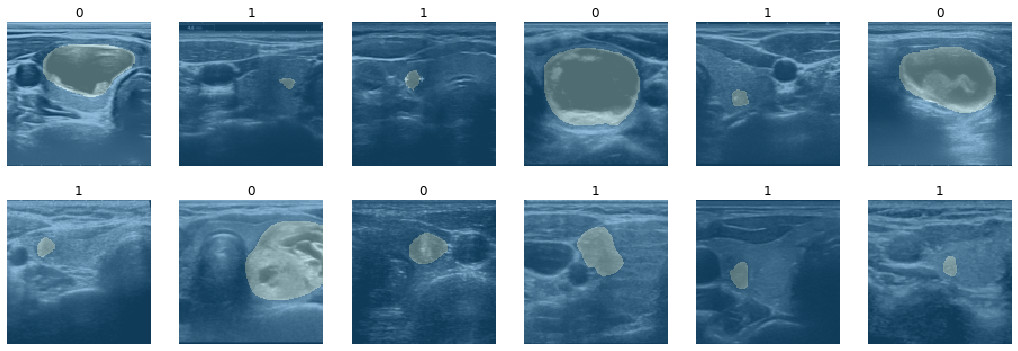

In [7]:
vcvc = DataBlock(blocks=blocks,
                 #get_items=get_image_files,
                 getters=getters,
                 item_tfms=Resize(128),
                 n_inp=1)

g = vcvc.dataloaders(labs, bs=16, num_workers=0)
g.show_batch(max_n=12, nrows=2, ncols=6)

In [8]:
batch = g.one_batch()
print(batch[0].shape)
print(batch[1].shape)
print(batch[2].shape)

torch.Size([16, 3, 128, 128])
torch.Size([16])
torch.Size([16, 128, 128])


In [9]:
g = g.cuda()
dice = Dice()

In [40]:
class CombinationLoss(Module):
    "Cross Entropy Loss on multiple targets"
    def __init__(self, func=F.cross_entropy):
        self.func, self.w = func, weights=[1,1]

    def forward(self, xs, *ys, reduction='mean'):
        for i, w, x, y in zip(range(len(xs)), self.w, xs, ys):
            if i == 0: loss = w*self.func(x, y, reduction=reduction) 
            else: loss += w*self.func(x, y, reduction=reduction) 
        return loss

In [19]:
lossn = nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=2, reduce=None, reduction='mean')

In [48]:
class MultiTargetLoss(Module):
    """Provides the ability to apply different loss functions to multi-modal targets/predictions"""
    def __init__(self, loss_classes=[CrossEntropyLossFlat, CrossEntropyLossFlat], loss_classes_kwargs=[{}, {}],
                 weights=[1, 1], reduction='mean'):

        loss_funcs = [ cls(**kwargs, reduction=reduction) for cls, kwargs in zip(loss_classes, loss_classes_kwargs) ]
        store_attr(self, 'loss_funcs, weights')
        self._reduction = reduction
        
    @property
    def reduction(self): return self._reduction
    
    @reduction.setter
    def reduction(self, v): 
        self._reduction = v
        for lf in self.loss_funcs: lf.reduction = v

    def forward(self, outputs, *targets, **kwargs):
        loss = 0.
        for i, loss_func, weights, output, target in zip(range(len(outputs)),
                                                         self.loss_funcs, self.weights,
                                                         outputs, targets):
            loss += weights * loss_func(output, target, **kwargs)

        pdb.set_trace()
        return loss

    def activation(self, outs):
        acts = [ self.loss_funcs[i].activation(o) for i, o in enumerate(outs) ]
        return acts

    def decodes(self, outs):
        decodes = [ self.loss_funcs[i].decodes(o) for i, o in enumerate(outs) ]
        return decodes

In [66]:
class CombinedLossLL(nn.Module):
    
    def forward(self, output, target):
        pct = uniform(0,1)
        loss = nn.CrossEntropyLoss(output, target)
        self.loss1 = pct * loss
        self.loss2 = (1-pct) * loss
        return loss

In [60]:
class CrossEntropyFlatL(nn.CrossEntropyLoss):
    def forward(self, input, target, target2):
        n,c,*_ = input.shape
        return super().forward(input.view(n, c, -1), target.view(n, -1), target2.view(n, -1))

In [69]:
learn = unet_learner(g, resnet18, metrics=dice, loss_func=flatten_check, n_out=3)

In [70]:
learn.fit_one_cycle(1, 1e-1)

TypeError: flatten_check() takes 2 positional arguments but 3 were given